In [1]:
import pickle
import numpy as np
import pandas as pd
import ruptures as rpt
from pathlib import Path
from scipy.io import loadmat
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from step.data import *
from step.models import *
#from step.utils import diffusion_coefficient_tmsd

from tqdm.auto import tqdm
from fastai.vision.all import *

# Analysis functions

In [2]:
# Defino esto aquí para que no tengas que instalar la librería
def tamsd(x, dt=1):
    "Computes the time averaged mean squared displacement of a trajectory `x`."
    return ((x[dt:] - x[:-dt])**2).sum(-1).mean()

def diffusion_coefficient_tamsd(x, t_lag=[1, 2]):
    "Estimates the diffusion coefficient fitting the `tmsd` for different `dt`."
    tamsds = [tamsd(x, dt) for dt in t_lag]
    D = np.polyfit(t_lag, tamsds, 1)[0]
    return D/2/x.shape[-1]

In [3]:
import math
 
def get_angle(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = math.degrees(np.arccos(dot_product))
    d = np.cross(vector_2,vector_1)
    return ang if d < 0 else -ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

def confinement_radius(x, nm_per_pxl=160):
    """Compute the confinement radius of a trajectory segment."""
    cov = np.cov(x)
    e_vals, _ = np.linalg.eigh(cov)
    return 2 * nm_per_pxl * np.sqrt(e_vals.mean())

## Load the data

We start our analysis by loading the trajectories with their predictions.

In [4]:
import mat73

In [5]:
#Processing for 1 Matlab variable
data_path = "E:/Shares/SMB_files/Jessica/video_220713_s2_c5.mat"
file = mat73.loadmat(data_path)
data_x, data_y = file["var1"]["video_file"][3:5]
all_trajectories = []
for x, y in zip(data_x, data_y):
    x = torch.tensor(x[~np.isnan(x)])
    y = torch.tensor(y[~np.isnan(y)])
    if len(x) >= 12: # at least > 0
        traj = torch.stack((x-x[0], y-y[0]))
        all_trajectories.append(traj)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'E:/Shares/SMB_files/Jessica/video_220713_s2_c5.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
##Processing for multiple Matlab variables
from tkinter import Tk, filedialog

In [8]:
# Create the Tkinter root window (it won't be shown)
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [9]:
# Create an empty list to store all trajectories
all_trajectories = []

# Loop through each selected file
for data_path in data_paths:
    file = mat73.loadmat(data_path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"]["video_file"][3:5]

    # Create a list to store trajectories for the current file
    trajectories = []

    # Loop through x and y data and create trajectories
    for x, y in zip(data_x, data_y):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        if len(x) >= 12:  # At least > 0
            traj = torch.stack((x - x[0], y - y[0]))
            trajectories.append(traj)

    # Append trajectories of the current file to the overall list
    all_trajectories.extend(trajectories)

ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)


In [7]:
# Create the Tkinter root window for the second dataset
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [8]:
# Create an empty list to store all trajectories
all_trajectories2 = []

# Loop through each selected file
for data_path in data_paths:
    file = mat73.loadmat(data_path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"]["video_file"][3:5]

    # Create a list to store trajectories for the current file
    trajectories = []

    # Loop through x and y data and create trajectories
    for x, y in zip(data_x, data_y):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        if len(x) >= 12:  # At least > 0
            traj = torch.stack((x - x[0], y - y[0]))
            trajectories.append(traj)

    # Append trajectories of the current file to the overall list
    all_trajectories2.extend(trajectories)

ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB

# Load the model

In [10]:
model_dir = "../../models"
dim = 2

In [11]:
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets

# Diffusion coefficient
# model_diff = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], pos_enc=False,
#                  n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[], norm=False, yrange=(-3.1, 3.1))
# model_diff = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], pos_enc=False,
#                  n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[], norm=False, yrange=(-4.1, 4.1))
model_diff = LogXResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], pos_enc=False,
                         n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[], norm=False, yrange=(-7.1, 2.1))
model_diff.to(default_device())

# Anomalous exponent
model_exp = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], 
                     pos_enc=False, n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[])
model_exp.to(default_device())

# Create the learners
learn_diff = Learner(dls, model_diff, loss_func=L1LossFlat(), model_dir=model_dir)
learn_exp = Learner(dls, model_exp, loss_func=L1LossFlat(), model_dir=model_dir)

C:\Users\jangulo\AppData\Local\miniconda3\envs\step_env\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\jangulo\AppData\Local\miniconda3\envs\step_env\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


In [21]:
# Load diffusion model
learn_diff.load(f'logxresattn_bm_{dim}d_1_to_4_cp_juan_72')
learn_diff.model.eval();

In [17]:
#Load alpha model
learn_exp.load(f'xresattn_exp_{dim}d_no_pe_2')
learn_exp.model.eval();

# Get predictions

In [22]:
def predict(model, x):
    return to_detach(model(x.cuda().T.unsqueeze(0).float()).squeeze())

In [20]:
pred_d = [predict(learn_diff.model, traj) for traj in all_trajectories]
pred_d2 = [predict(learn_diff.model, traj) for traj in all_trajectories2]

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
pred_alpha = [predict(learn_diff.model, traj) for traj in all_trajectories]
pred_alpha2 = [predict(learn_diff.model, traj) for traj in all_trajectories2]

# Ensamble histograms

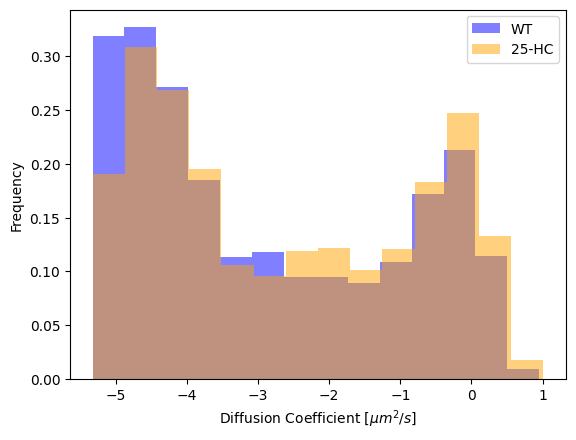

In [17]:
data = torch.cat(pred_d).numpy()
data2 = torch.cat(pred_d2).numpy()
bin_size1 = int(np.ceil(np.log10(len(data))) + 1)
bin_size2 = int(np.ceil(np.log10(len(data2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(data, bins=chosen_bin_size, alpha=0.5, color='blue', label='WT', density=True)
plt.hist(data2, bins=chosen_bin_size, alpha=0.5, color='orange', label='25-HC', density=True)
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

In [18]:
preds_mean = [p.mean().numpy().item() for p in preds]
preds_mean2 = [p.mean().numpy().item() for p in preds2]

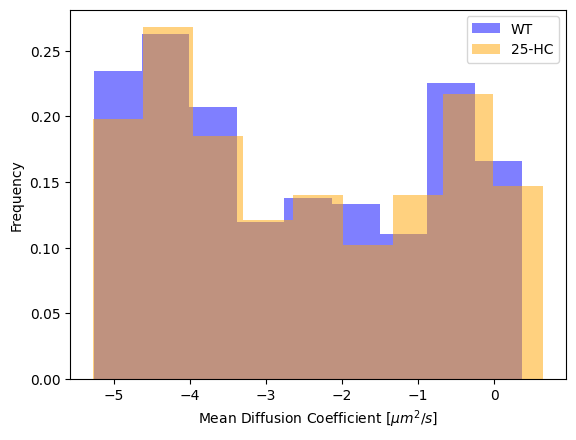

In [21]:
bin_size1 = int(np.ceil(np.log2(len(preds_mean))) + 1)
bin_size2 = int(np.ceil(np.log2(len(preds_mean2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(preds_mean, bins=chosen_bin_size, alpha=0.5, color='blue', label='WT', density=True);
plt.hist(preds_mean2, bins=chosen_bin_size, alpha=0.5, color='orange', label='25-HC', density=True);
plt.xlabel('Mean Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

# Prediction examples

(-5.0, 1.0)

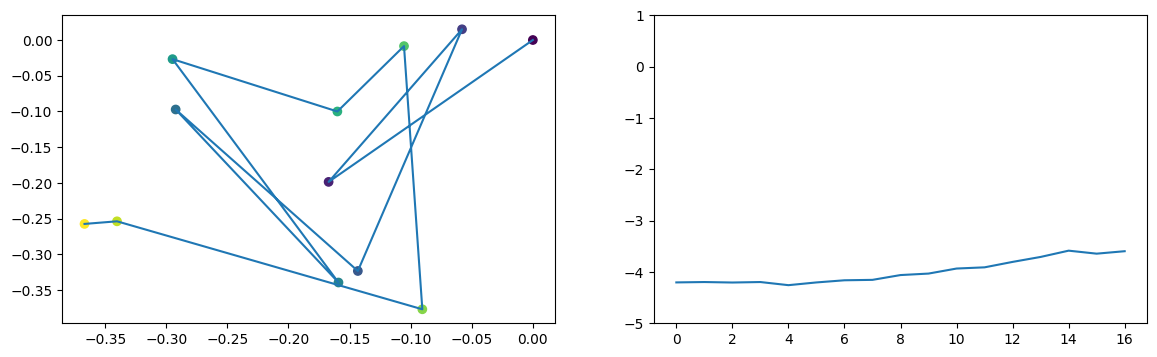

In [31]:
idx = 9
traj = trajectories[idx]

fix, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(traj[0], traj[1])
axes[0].scatter(traj[0], traj[1], c=np.arange(len(traj[0])))

axes[1].plot(preds[idx])
axes[1].set_ylim(-5, 1)

# Trajectory segmentation

x   -1.039064
Name: 0, dtype: float32


In [97]:
def find_segments(pred_d, traj, pen=1, **kwargs):
    import ruptures as rpt
    alg = rpt.KernelCPD(**kwargs).fit(pred_d) # Only changes in D
    #alg = rpt.KernelCPD(**kwargs).fit(pred)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, Ds_tamsd, angles = [], [], [], []   
    new_d = np.ones_like(pred_d)
    d_tamsd = np.ones_like(pred_d)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        D_seg = pred_d[i:j].mean()
        new_d[i:j] *= D_seg
        t_lag = [2, 3, 4] if j-i >= 5 else [2, 3]
        D_tamsd = np.log10(diffusion_coefficient_tmsd(tensor(segment).T, t_lag))
        d_tamsd[i:j] *= D_tamsd
        if np.abs(i-j) > 0:
            angles.append(dataset_angles([segment]))
            segments.append(segment)
        Ds.append(D_seg)
        Ds_tamsd.append(D_tamsd)

    return new_d, d_tamsd, segments, Ds, Ds_tamsd, angles

In [ ]:
# Convert preds and all_trajectories into a compatible DataFrames (df)


In [ ]:
# Get segmentation done
seg_ds, seg_ds_tamsd, seg_angs  = [], [], [], [], []
for traj, pred_d in tqdm(zip(all_trajectories, preds)):
    x, y = traj[0], traj[1]
    # traj = np.array([x-x[0], y-y[0]])
    traj = np.concatenate([np.zeros((2, 1)), np.array([x, y])], axis=1)
    out = find_segments(pred_d, traj, min_size=4, pen=0.05) # previously min_size=10, pen=0.1
    new_d, d_tamsd, segments, d_seg, dtamsd_seg, angs = out
    exp.df.loc[mask, 'D_segment'] = new_d
    exp.df.loc[mask, 'D_24_segment'] = d_tamsd
    seg_ds.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_angs.append(angs)
    seg_exp.append([exp_idx]*len(segments))
    trajs.append(segments)
seg_ds = np.concatenate(seg_ds)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)
seg_exp = np.concatenate(seg_exp)

exp.trajs = trajs
exp.seg_ds = seg_ds
exp.seg_ds_tamsd = seg_ds_tamsd
exp.seg_alphas = seg_alphas
exp.seg_angs = seg_angs
exp.seg_lens = np.array([seg.shape[-1] for traj in exp.trajs for seg in traj])
exp.seg_radi = [[confinement_radius(seg) for seg in traj] for traj in exp.trajs]
exp.seg_exp = seg_exp

In [96]:
def find_segments(pred_d, pred_alpha, traj, pen=1, **kwargs):
    import ruptures as rpt
    alg = rpt.KernelCPD(**kwargs).fit(pred_d) # Only changes in D
    #alg = rpt.KernelCPD(**kwargs).fit(pred)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, Ds_tamsd, alphas, angles = [], [], [], [], []
            
    new_d, new_a = np.ones_like(pred_d), np.ones_like(pred_alpha)
    d_tamsd = np.ones_like(pred_d)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        alpha_seg, D_seg = pred_alpha[i:j].mean(), pred_d[i:j].mean()
        new_d[i:j] *= D_seg
        new_a[i:j] *= alpha_seg
        
        t_lag = [2, 3, 4] if j-i >= 5 else [2, 3]
        D_tamsd = np.log10(diffusion_coefficient_tmsd(tensor(segment).T, t_lag)) + real_units_factor
        d_tamsd[i:j] *= D_tamsd
        
        if np.abs(i-j) > 0:
            angles.append(dataset_angles([segment]))
            segments.append(segment)
        alphas.append(alpha_seg)
        Ds.append(D_seg)
        Ds_tamsd.append(D_tamsd)

    return new_d, d_tamsd, new_a, segments, Ds, Ds_tamsd, alphas, angles

In [ ]:
for exp in experiments.values(): 
    trajs = []
    seg_ds, seg_ds_tamsd, seg_alphas, seg_angs, seg_exp = [], [], [], [], []

    for idx in tqdm(np.unique(exp.df.traj_idx)):
        mask = exp.df.traj_idx == idx
        exp_idx = int(exp.df.loc[mask, 'exp_idx'].values[0])
        pred_d = exp.df.loc[mask, 'D_tfm'].values
        pred_alpha = exp.df.loc[mask, 'alpha'].values
        x, y = exp.df[mask].x.values, exp.df[mask].y.values
        # traj = np.array([x-x[0], y-y[0]])
        traj = np.concatenate([np.zeros((2, 1)), np.array([x, y])], axis=1)

        out = find_segments(pred_d, pred_alpha, traj, min_size=4, pen=0.05) # previously min_size=10, pen=0.1
        new_d, d_tamsd, new_a, segments, d_seg, dtamsd_seg, a_seg, angs = out

        exp.df.loc[mask, 'D_segment'] = new_d
        exp.df.loc[mask, 'alpha_segment'] = new_a
        exp.df.loc[mask, 'D_24_segment'] = d_tamsd
        seg_ds.append(d_seg)
        seg_ds_tamsd.append(dtamsd_seg)
        seg_alphas.append(a_seg)
        seg_angs.append(angs)
        seg_exp.append([exp_idx]*len(segments))
        trajs.append(segments)
    seg_ds = np.concatenate(seg_ds)
    seg_ds_tamsd = np.concatenate(seg_ds_tamsd)
    seg_alphas = np.concatenate(seg_alphas)
    seg_exp = np.concatenate(seg_exp)
    
    exp.trajs = trajs
    exp.seg_ds = seg_ds
    exp.seg_ds_tamsd = seg_ds_tamsd
    exp.seg_alphas = seg_alphas
    exp.seg_angs = seg_angs
    exp.seg_lens = np.array([seg.shape[-1] for traj in exp.trajs for seg in traj])
    exp.seg_radi = [[confinement_radius(seg) for seg in traj] for traj in exp.trajs]
    exp.seg_exp = seg_exp